In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [66]:
import os
import time
import random
import glob
import json
import collections
from typing import List, Tuple, Dict


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm


import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


import matplotlib.pyplot as plt
import seaborn as sns

In [67]:

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [79]:
# Constants

TRAIN_PATH = 'rsna-2024-lumbar-spine-degenerative-classification/'

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load and return all necessary dataframes."""
    train = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
    label = pd.read_csv(os.path.join(TRAIN_PATH, 'train_label_coordinates.csv'))
    train_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'train_series_descriptions.csv'))
    test_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'test_series_descriptions.csv'))
    sub = pd.read_csv(os.path.join(TRAIN_PATH, 'sample_submission.csv'))
    return train, label, train_desc, test_desc, sub

In [80]:
def generate_image_paths(df: pd.DataFrame, data_dir: str) -> List[str]:
    """Generate image paths based on directory structure."""
    image_paths = []
    for _, row in df.iterrows():
        study_dir = os.path.join(data_dir, str(row['study_id']))
        series_dir = os.path.join(study_dir, str(row['series_id']))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

In [81]:
# Load data
train, label, train_desc, test_desc, sub = load_data()
os.getcwd()

'/Users/paulgarell/workingDir/RSNA2024spine_kaggle'

In [82]:
# Display some data
print("Test Series Descriptions:")
print(test_desc.head())
print("\nTrain Data:")
print(train.head())
print("\nTrain Series Descriptions:")
print(train_desc.head())

Test Series Descriptions:
   study_id   series_id series_description
0  44036939  2828203845        Sagittal T1
1  44036939  3481971518           Axial T2
2  44036939  3844393089   Sagittal T2/STIR

Train Data:
   study_id spinal_canal_stenosis_l1_l2 spinal_canal_stenosis_l2_l3  \
0   4003253                 Normal/Mild                 Normal/Mild   
1   4646740                 Normal/Mild                 Normal/Mild   
2   7143189                 Normal/Mild                 Normal/Mild   
3   8785691                 Normal/Mild                 Normal/Mild   
4  10728036                 Normal/Mild                 Normal/Mild   

  spinal_canal_stenosis_l3_l4 spinal_canal_stenosis_l4_l5  \
0                 Normal/Mild                 Normal/Mild   
1                    Moderate                      Severe   
2                 Normal/Mild                 Normal/Mild   
3                 Normal/Mild                 Normal/Mild   
4                 Normal/Mild                 Normal/Mild

In [83]:
# Generate image paths
train_image_paths = generate_image_paths(train_desc, os.path.join(TRAIN_PATH, 'train_images'))
test_image_paths = generate_image_paths(test_desc, os.path.join(TRAIN_PATH, 'test_images'))

print(f"\nNumber of train images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
len(train_desc)


Number of train images: 147218
Number of test images: 97


6294

In [84]:
def load_dicom_files(path_to_folder: str) -> List[str]:
    """Load DICOM files from a folder and sort them."""
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    return sorted(files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))

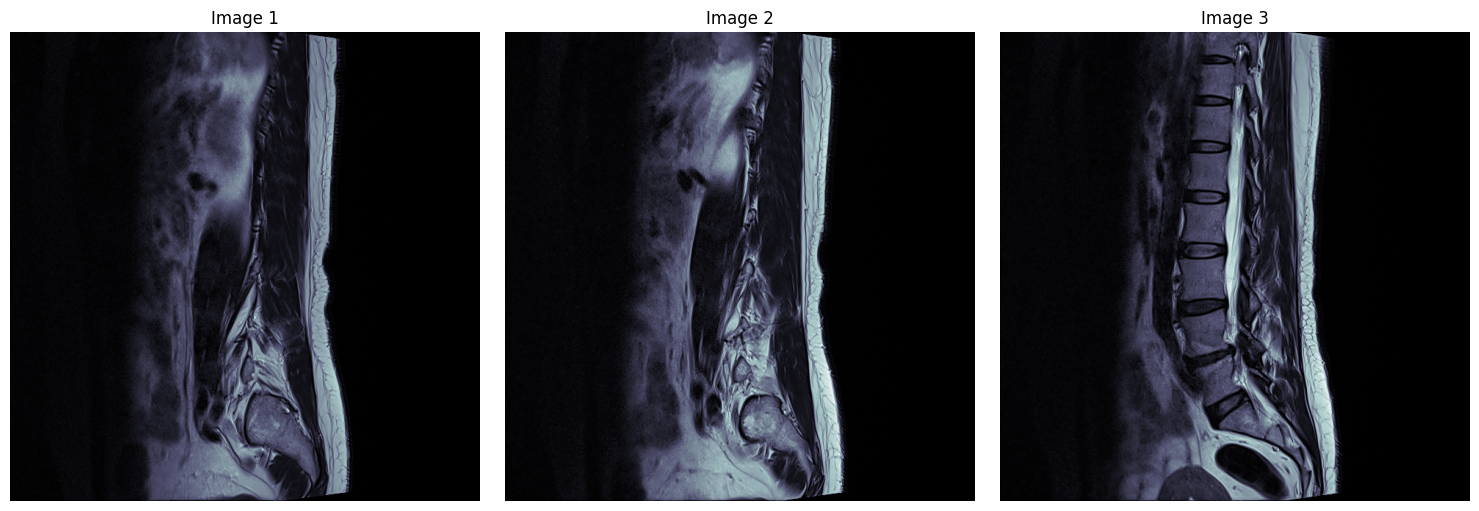

In [86]:
def display_dicom_images(image_paths: List[str], num_images: int = 3):
    """Display a specified number of DICOM images."""
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
    for i, path in enumerate(image_paths[:num_images]):
        ds = pydicom.dcmread(path)
        ax = axes[i] if num_images > 1 else axes
        ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
        ax.set_title(f"Image {i+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_dicom_images(train_image_paths)

In [13]:
def display_dicom_with_coordinates(image_paths: List[str], label_df: pd.DataFrame):
    """Display DICOM images along with coordinates."""
    fig, axes = plt.subplots(1, len(image_paths), figsize=(6*len(image_paths), 6))
    axes = [axes] if len(image_paths) == 1 else axes
    
    # Group labels by study_id and series_id for faster lookup
    label_dict = defaultdict(list)
    for _, row in label_df.iterrows():
        label_dict[(row['study_id'], row['series_id'])].append((row['x'], row['y']))
    
    for idx, path in enumerate(image_paths):
        study_id = int(path.split('/')[-3])
        series_id = int(path.split('/')[-2])
        
        ds = pydicom.dcmread(path)
        axes[idx].imshow(ds.pixel_array, cmap='gray')
        axes[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axes[idx].axis('off')
        
        # Plot coordinates
        for x, y in label_dict.get((study_id, series_id), []):
            axes[idx].plot(x, y, 'ro', markersize=5)
    
    plt.tight_layout()
    plt.show()

In [14]:
 # Constants
TRAIN_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
STUDY_ID = "100206310"

# Load label data
label = pd.read_csv(os.path.join(TRAIN_PATH, 'train_label_coordinates.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv'

In [15]:
# Load DICOM images
study_folder = os.path.join(TRAIN_PATH, 'train_images', STUDY_ID)
image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series

# Display DICOM images with coordinates
display_dicom_with_coordinates(image_paths, label)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310'

In [16]:
import pandas as pd
from typing import Dict, List

# Constants
TRAIN_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'


def load_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load and return all necessary dataframes."""
    train = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
    label = pd.read_csv(os.path.join(TRAIN_PATH, 'train_label_coordinates.csv'))
    train_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'train_series_descriptions.csv'))
    test_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'test_series_descriptions.csv'))
    sub = pd.read_csv(os.path.join(TRAIN_PATH, 'sample_submission.csv'))
    return train, label, train_desc, test_desc, sub


In [17]:
def reshape_row(row: pd.Series) -> pd.DataFrame:
    """Reshape a single row of the DataFrame into a new format."""
    data: Dict[str, List] = {'study_id': [], 'condition': [], 'level': [], 'severity': []}


In [18]:
def reshape_row(row: pd.Series) -> pd.DataFrame:
    """Reshape a single row of the DataFrame into a new format."""
    data: Dict[str, List] = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join(word.capitalize() for word in parts[:-2])
            level = f"{parts[-2].capitalize()}/{parts[-1].capitalize()}"
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)


In [19]:
def preprocess_train_data(train: pd.DataFrame, label: pd.DataFrame, train_desc: pd.DataFrame) -> pd.DataFrame:
    """Preprocess and merge the training data."""
    new_train_df = pd.concat((reshape_row(row) for _, row in train.iterrows()), ignore_index=True)
    merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
    final_merged_df = pd.merge(merged_df, train_desc, on=['series_id', 'study_id'], how='inner')
    
    final_merged_df['row_id'] = (
        final_merged_df['study_id'].astype(str) + '_' +
        final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
        final_merged_df['level'].str.lower().str.replace('/', '_')
    )
    
    final_merged_df['image_path'] = (
        f'{TRAIN_PATH}/train_images/' + 
        final_merged_df['study_id'].astype(str) + '/' +
        final_merged_df['series_id'].astype(str) + '/' +
        final_merged_df['instance_number'].astype(str) + '.dcm'
    )
    
    final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})
    
    return final_merged_df

In [20]:
def get_image_paths(row: pd.Series) -> List[str]:
    """Get image paths for a series."""
    series_path = os.path.join(TRAIN_PATH, 'test_images', str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

In [21]:
def preprocess_test_data(test_desc: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the test data."""
    condition_mapping = {
        'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
        'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
        'Sagittal T2/STIR': 'spinal_canal_stenosis'
    }

    expanded_rows = []
    for _, row in test_desc.iterrows():
        image_paths = get_image_paths(row)
        conditions = condition_mapping.get(row['series_description'], {})
        if isinstance(conditions, str):
            conditions = {'left': conditions, 'right': conditions}
        for side, condition in conditions.items():
            for image_path in image_paths:
                expanded_rows.append({
                    'study_id': row['study_id'],
                    'series_id': row['series_id'],
                    'series_description': row['series_description'],
                    'image_path': image_path,
                    'condition': condition,
                    'row_id': f"{row['study_id']}_{condition}"
                })

    return pd.DataFrame(expanded_rows)

In [22]:
def check_path_exists(path: str) -> bool:
    """Check if a path exists."""
    return os.path.exists(path)

In [23]:
def validate_train_data(train_data: pd.DataFrame) -> pd.DataFrame:
    """Validate and filter the train data."""
    train_data['study_id_exists'] = train_data.apply(lambda row: check_path_exists(f'{TRAIN_PATH}/train_images/{row["study_id"]}'), axis=1)
    train_data['series_id_exists'] = train_data.apply(lambda row: check_path_exists(f'{TRAIN_PATH}/train_images/{row["study_id"]}/{row["series_id"]}'), axis=1)
    train_data['image_exists'] = train_data['image_path'].apply(check_path_exists)
    
    return train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [24]:
def load_dicom(path: str) -> np.ndarray:
    """Load and preprocess a DICOM image."""
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [25]:
def plot_sample_images(train_data: pd.DataFrame, num_samples: int = 2):
    """Plot sample images from the training data."""
    selected_indices = random.sample(range(len(train_data)), num_samples)
    images = [load_dicom(train_data['image_path'].iloc[i]) for i in selected_indices]
    row_ids = [train_data['row_id'].iloc[i] for i in selected_indices]

    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    for i, (image, row_id) in enumerate(zip(images, row_ids)):
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Row ID: {row_id}', fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:
# Load data
train, label, train_desc, test_desc, sub = load_data()
# Preprocess train data
train_data = preprocess_train_data(train, label, train_desc)
train_data = validate_train_data(train_data)
# Preprocess test data
test_data = preprocess_test_data(test_desc)
# Display some information
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv'

In [27]:
# Plot sample images
plot_sample_images(train_data)

NameError: name 'train_data' is not defined

In [28]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index]['image_path']
        image = load_dicom(image_path)
        label = self.dataframe.iloc[index]['severity']
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

In [30]:
# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [31]:
# Create dataloaders for each series description
dataloaders = {}
lengths = {}

In [32]:
for desc in ['Sagittal T1', 'Axial T2', 'Sagittal T2/STIR']:
    trainloader, valloader, len_train, len_val = create_datasets_and_loaders(train_data, desc, transform)
    dataloaders[desc] = (trainloader, valloader)
    lengths[desc] = (len_train, len_val)
# Visualize samples from each dataloader
for desc in dataloaders:
    print(f"Visualizing {desc} samples")
    visualize_batch(dataloaders[desc][0], f"{desc} Samples")

NameError: name 'train_data' is not defined

In [33]:
# Dictionary mapping labels to indices
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
# Display a single sample
trainloader = dataloaders['Axial T2'][0]
image, label = next(iter(trainloader))
sample = image[0].permute(1, 2, 0)

KeyError: 'Axial T2'

In [34]:
def visualize_batch(dataloader, title):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC for visualization
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [35]:
plt.figure(figsize=(8, 4))
plt.imshow(sample, cmap='gray')
plt.title(f"Label: {label[0]}")
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'sample' is not defined

<Figure size 800x400 with 0 Axes>

In [40]:
import torch